In [1]:
import tensorflow as tf

In [2]:
from tensorflow import keras
import pandas as pd

In [3]:
testdata = pd.read_csv('./datasets/test/_annotations.csv')
traindata = pd.read_csv('./datasets/train/_annotations.csv')
validdata = pd.read_csv('./datasets/valid/_annotations.csv')

In [4]:
testdata

,filename,width,height,class,xmin,ymin,xmax,ymax
0,Screen-Shot-2022-02-14-at-1-09-28-PM_png.rf.00...,640,640,Paper,0,73,156,483
1,egohands-public-1623358709389_png_jpg.rf.01566...,640,640,Paper,131,40,277,234
2,20220216_221550_jpg.rf.02a071a383151953fcf8671...,640,640,Scissors,137,321,531,479
3,zoom_tests_RockPaperScissors-mohamed_mp4-87_jp...,640,640,Rock,22,250,258,640
4,egohands-public-1622730832103_png_jpg.rf.11458...,640,640,Scissors,388,24,634,264
...,...,...,...,...,...,...,...,...
212,Screen-Recording-2023-03-11-at-9_48_18-PM_mov-...,640,640,Rock,362,254,381,288
213,Screen-Recording-2023-03-11-at-9_48_18-PM_mov-...,640,640,Rock,251,263,273,311
214,IMG_7079_MOV-8_jpg.rf.f6ecee3ccaaba4956faf5a4a...,640,640,Rock,25,260,345,498
215,zoom_tests_RockPaperScissors-mohamed_mp4-137_j...,640,640,Paper,211,85,385,608


In [5]:
import cv2
import matplotlib.pyplot as plt

In [6]:
y_train = traindata[['xmin', 'ymin', 'xmax', 'ymax']]
y_test = testdata[['xmin', 'ymin', 'xmax', 'ymax']]
y_valid = validdata[['xmin', 'ymin', 'xmax', 'ymax']]
y_test

,xmin,ymin,xmax,ymax
0,0,73,156,483
1,131,40,277,234
2,137,321,531,479
3,22,250,258,640
4,388,24,634,264
...,...,...,...,...
212,362,254,381,288
213,251,263,273,311
214,25,260,345,498
215,211,85,385,608


In [7]:
def process_image(row, folder):
    image_path = './datasets/' + folder + '/' + row['filename']
    img = cv2.imread(image_path)
    # img = cv2.rectangle(img, (row['xmin'], row['ymin']), (row['xmax'], row['ymax']), (0, 255, 0), 2)
    # img_cropped = img[row['ymin']:row['ymax'], row['xmin']:row['xmax']]
    img_resized = cv2.resize(img, (32, 32))
    return img_resized

In [8]:
testdf = testdata.apply(process_image, axis=1, args=("test",))

In [9]:
testdf

0      [[[219, 219, 219], [73, 73, 73], [6, 6, 6], [7...
1      [[[85, 90, 59], [91, 69, 19], [100, 74, 18], [...
2      [[[115, 185, 208], [119, 198, 219], [128, 206,...
3      [[[101, 118, 121], [113, 126, 125], [150, 153,...
4      [[[75, 78, 62], [67, 74, 59], [71, 77, 60], [6...
                             ...                        
212    [[[132, 137, 128], [185, 189, 178], [187, 191,...
213    [[[132, 137, 128], [185, 189, 178], [187, 191,...
214    [[[207, 72, 164], [208, 74, 164], [210, 74, 16...
215    [[[96, 111, 110], [120, 126, 125], [143, 147, ...
216    [[[223, 218, 218], [148, 137, 137], [123, 109,...
Length: 217, dtype: object

In [10]:
traindf = traindata.apply(process_image, axis=1, args=("train",))

In [11]:
validdf = validdata.apply(process_image, axis=1, args=("valid",))

In [12]:
import numpy as np
testdf = testdf.to_numpy()
testdf = [tf.convert_to_tensor(item) for item in testdf]
testdf = tf.convert_to_tensor(testdf)

In [13]:
traindf = traindf.to_numpy()

In [14]:
traindf = [tf.convert_to_tensor(item) for item in traindf]
traindf = tf.convert_to_tensor(traindf)

In [15]:
validdf = validdf.to_numpy()

In [16]:
validdf = [tf.convert_to_tensor(item) for item in validdf]
validdf = tf.convert_to_tensor(validdf)

In [17]:
x_train, x_test, x_valid = traindf/255 , testdf/255 , validdf/255

In [18]:
x_train.shape

TensorShape([7821, 32, 32, 3])

In [19]:
from tensorflow.keras import layers , models

### Trying Something New -> Wait for it

In [20]:
import numpy as np



def iou_calc(true_bbox , selectivesarch_bbox):
    '''
    true_bbox           : true bounding box  
    selectivesarch_bbox : bounding box output from selective search algorithm
    
    '''
  
    true_xmin, true_ymin, true_width, true_height  = true_bbox
    bb_xmin, bb_ymin,  bb_width, bb_height = selectivesarch_bbox

    true_xmax = true_xmin + true_width
    true_ymax = true_ymin + true_height
    bb_xmax = bb_xmin + bb_width
    bb_ymax = bb_ymin + bb_height

    #calculating area
    true_area = true_width * true_height
    bb_area   = bb_width * bb_height 

    #calculating itersection cordinates
    inter_xmin = max(true_xmin , bb_xmin) 
    inter_ymin = max(true_ymin , bb_ymin)
    inter_xmax = min(true_xmax , bb_xmax)
    inter_ymax = min(true_ymax , bb_ymax)

    if inter_xmax <= inter_xmin or inter_ymax <= inter_ymin:
        iou = 0


    else:
        inter_area = (inter_xmax - inter_xmin) * (inter_ymax - inter_ymin)


        iou = inter_area / (true_area + bb_area - inter_area)
        
    assert iou<=1
    assert iou>=0
    
    return iou
                    
                    
            

In [21]:
import cv2

In [22]:
# import cv2.ximgproc  # import the ximgproc module
cv2.setUseOptimized(True)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [23]:
image_path = './datasets/' + 'test' + '/' + 'youtube-25_jpg.rf.121bbf3873487349ba7e5e2cde55dcef.jpg'
img = cv2.imread(image_path)
img = cv2.resize(img, (240, 240))
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()

In [24]:
import matplotlib.pyplot as plt

In [25]:
rects = ss.process()

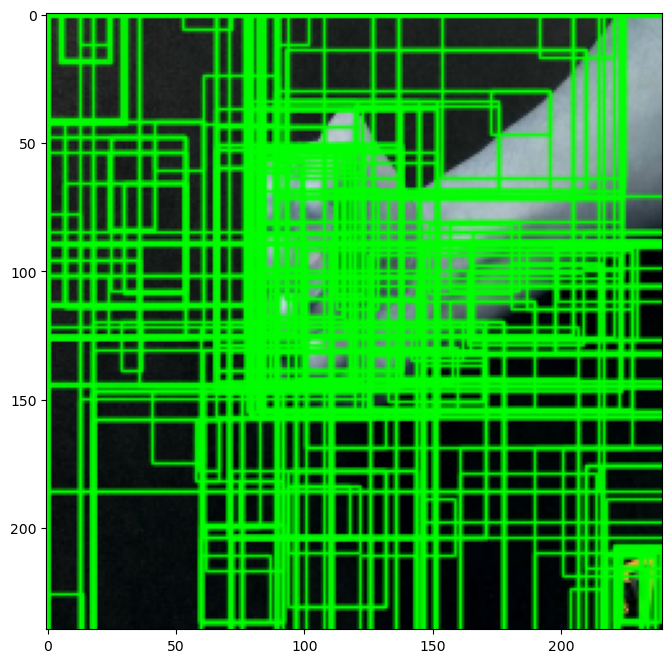

In [26]:
sel_rects = rects[:1200]
imOut = img.copy()
for i, rect in (enumerate(sel_rects)):
    x, y, w, h = rect
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.figure(figsize=(8,8))
plt.imshow(imOut)

In [27]:
import pandas as pd
import numpy as np
import cv2

cv2.setUseOptimized(True)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()


def iou_filter(image_path,img_name,true_bb,thresh=0.5):
    
    '''
    arguments:
    1. image_path: path of images 
    2. true_bb: true labeled dataframe of image columns = ['filename','width','height','class','xmin','ymin','xmax','ymax']
    3. thresh: threshhold value for intersection over union(iou), by default 0.5
    
    returns:
    filtered_selective_search: rigion which iou is higher than threshhold value of given image and class of that object
    negative_example         : return region which iou is less than thresh value and not conflict with other object region
    
    '''

    # image_path = './datasets/' + 'test' + '/' + 'youtube-25_jpg.rf.121bbf3873487349ba7e5e2cde55dcef.jpg'
    # img = cv2.imread(image_path)
    # ss.setBaseImage(img)
    # ss.switchToSelectiveSearchFast()
    print(image_path)
    
    img_bb = true_bb[true_bb['filename']==img_name].reset_index(drop=True)
    
    img = cv2.imread(image_path)
    # img = cv2.resize(img,(600,600))
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    
    ss_bb = rects[:2000]
    
    filtered_selective_search = []

    negative_examples = []
    
    maybe_neagative = []
    
    # loop to compute iou for all label of perticular image
    for label in range(len(img_bb)):
        

        #unpacking cordinates
        true_xmin, true_ymin, true_width, true_height  = img_bb.loc[label,'xmin'], img_bb.loc[label,'ymin'], img_bb.loc[label,'xmax']-img_bb.loc[label,'xmin'], img_bb.loc[label,'ymax']-img_bb.loc[label,'ymin']
        class_of_label = img_bb.loc[label,'class']
        
        #loop to compute iou for all selective search of perticular label
        for j,rect in enumerate(ss_bb):
            calculating_iou_for_selectivesearch = iou_calc([true_xmin, true_ymin, true_width, true_height],rect)
            
            if calculating_iou_for_selectivesearch > thresh:
                filtered_selective_search.append([list(rect),class_of_label])
            
            elif calculating_iou_for_selectivesearch <0.5:
                maybe_neagative.append(list(rect))
    
    #removing duplicate entries
    
    def Remove(duplicate): 
        final_list = [] 
        for num in duplicate: 
            if num not in final_list: 
                final_list.append(num) 
        return final_list 

    maybe_neagative = Remove(maybe_neagative)
    filtered_selective_search = Remove(filtered_selective_search)
   

    #this is will use for background class for CNN which has iou less than 0.2, In paper it's 0.3 but in that also written that it's depends on dataset. 

    only_labels_of_filtered_selective_search = [x[0] for x in filtered_selective_search]

    for lab in maybe_neagative:
        condition = []    
        for true_lab in only_labels_of_filtered_selective_search:
            
            iou_for_negative_ex = iou_calc(true_lab,lab)
            
            condition.append(True) if iou_for_negative_ex <= 0.5  else condition.append(False)

        if False not in condition:
            negative_examples.append(lab)
    
    negative_examples = Remove(negative_examples)
    random_background_images_index = np.random.randint(low=0, high=len(negative_examples), size=2*len(only_labels_of_filtered_selective_search)) 
    random_background_images = [negative_examples[x] for x in random_background_images_index]

    
    return filtered_selective_search , Remove(random_background_images)

In [28]:
image_path2 = './datasets/' + 'train' + '/' + '0031_png.rf.01ee1fffe08da1e95a3c89e8d2f11711.jpg'
imagetestde = '0031_png.rf.01ee1fffe08da1e95a3c89e8d2f11711.jpg'

In [29]:
cs,neg =iou_filter(image_path2,imagetestde,traindata,thresh=0.55)

./datasets/train/0031_png.rf.01ee1fffe08da1e95a3c89e8d2f11711.jpg


In [30]:
cs

[[[203, 332, 49, 103], 'Scissors'],
 [[202, 341, 45, 94], 'Scissors'],
 [[202, 336, 52, 109], 'Scissors'],
 [[194, 332, 58, 103], 'Scissors'],
 [[165, 341, 82, 94], 'Scissors'],
 [[302, 400, 108, 74], 'Scissors'],
 [[297, 395, 121, 129], 'Scissors'],
 [[301, 399, 106, 91], 'Scissors'],
 [[302, 401, 106, 90], 'Scissors'],
 [[302, 401, 106, 88], 'Scissors'],
 [[306, 403, 104, 86], 'Scissors'],
 [[278, 374, 140, 116], 'Scissors'],
 [[297, 395, 98, 99], 'Scissors'],
 [[306, 403, 104, 71], 'Scissors'],
 [[300, 399, 107, 93], 'Scissors'],
 [[302, 401, 96, 88], 'Scissors'],
 [[303, 400, 104, 92], 'Scissors'],
 [[282, 386, 113, 108], 'Scissors'],
 [[308, 400, 99, 92], 'Scissors'],
 [[300, 420, 95, 74], 'Scissors'],
 [[308, 400, 99, 90], 'Scissors'],
 [[295, 396, 123, 94], 'Scissors'],
 [[297, 395, 121, 128], 'Scissors'],
 [[306, 403, 104, 87], 'Scissors'],
 [[301, 399, 117, 91], 'Scissors'],
 [[306, 403, 112, 86], 'Scissors'],
 [[302, 400, 116, 109], 'Scissors'],
 [[299, 416, 96, 78], 'Scissor

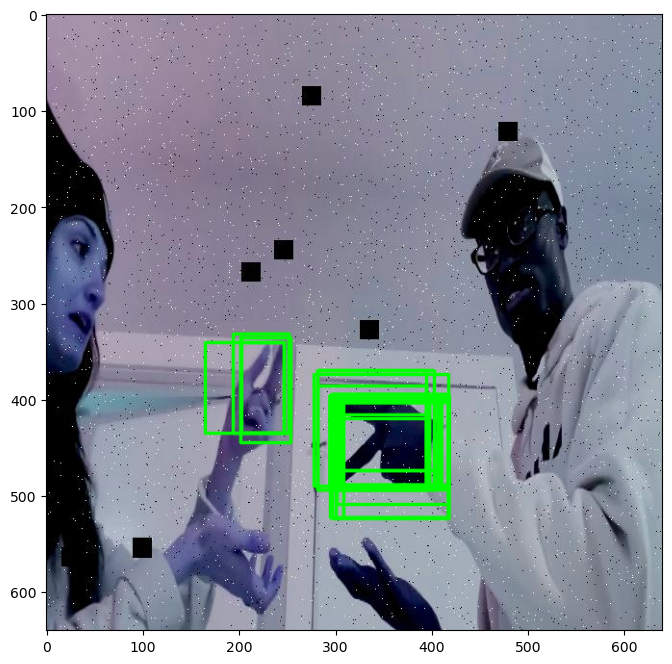

In [31]:
img = cv2.imread(image_path2)
# img = cv2.resize(img,(240,240))
for i, rect in (enumerate(cs)):
    x, y, w, h = rect[0]
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2, cv2.LINE_AA)
    
plt.figure(figsize=(12,8))
plt.imshow(img)

In [32]:
len(cs)

45

In [33]:
len(neg)

88

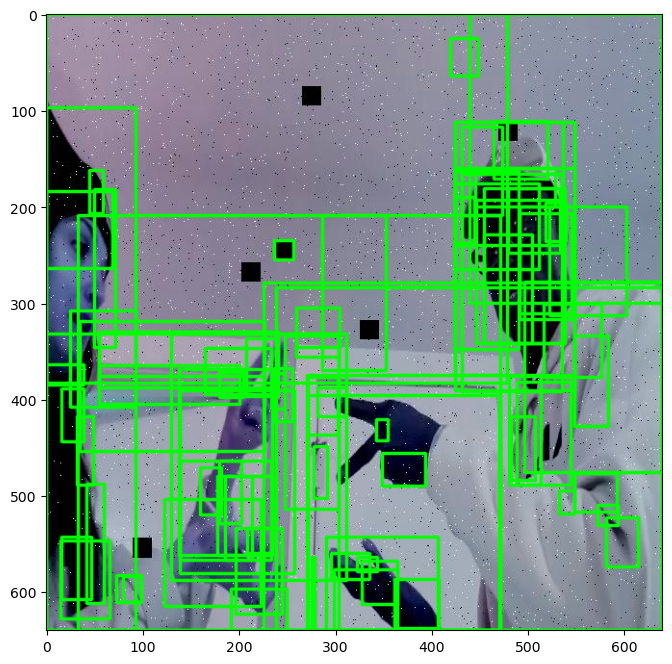

In [34]:
img = cv2.imread(image_path2)
for i, rect in (enumerate(neg)):
    x, y, w, h = rect
    
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2, cv2.LINE_AA)
    
    
plt.figure(figsize=(12,8))
plt.imshow(img)

In [35]:
train_data = {}
test_data  = {}

In [36]:
path2 = './datasets/' + 'train' + '/'

In [37]:
itr_arr = []
for file_path in traindata['filename']:
    itr_arr.append(file_path)
itr_arr

['zoom_tests_RockPaperScissors-mohamed_mp4-67_jpg.rf.000c94da234525180bcf003ce05e8ea1.jpg',
 'egohands-public-1625070649053_png_jpg.rf.000a5110e86a581124b82143dde75594.jpg',
 'zoom_tests_RockPaperScissors-mohamed_mp4-111_jpg.rf.0026014f030bc8948f695c72e7da80cb.jpg',
 'IMG_5636_MOV-61_jpg.rf.003476f680b71b74f3764a14153a634a.jpg',
 'IMG_5636_MOV-61_jpg.rf.003476f680b71b74f3764a14153a634a.jpg',
 'egohands-public-1626201626932_png_jpg.rf.001f745e10caeb2be82294d9ec919dc0.jpg',
 'IMG_7077_MOV-88_jpg.rf.00235d8ae3c3ac4a618ddde10a32c229.jpg',
 'IMG_7077_MOV-88_jpg.rf.00235d8ae3c3ac4a618ddde10a32c229.jpg',
 'IMG_7043_MOV-71_jpg.rf.0059209d24d383f7ac8f635535fb72ee.jpg',
 'egohands-public-1620849849796_png_jpg.rf.0041e991fdc55e1f524bea43748c38cd.jpg',
 'egohands-public-1620914959610_png_jpg.rf.0059e4dca308010da5962eab67e57d91.jpg',
 'egohands-public-1628521099042_png_jpg.rf.0036556afa2caf5d7a05287dd1488c30.jpg',
 'egohands-public-1622730814115_png_jpg.rf.00783125b4f09dcc4a7e713a0dd91a3b.jpg',
 'e

In [38]:
events_count = len(itr_arr[:10])
for i in range(events_count):
    cs, neg = iou_filter(path2 + itr_arr[i], itr_arr[i] ,traindata, thresh=0.5)
    train_data[itr_arr[i]] = {'region_proposal':cs,'negative_example':neg}
    finished = 100*(i/events_count)
    print(finished)


./datasets/train/zoom_tests_RockPaperScissors-mohamed_mp4-67_jpg.rf.000c94da234525180bcf003ce05e8ea1.jpg


0.0
./datasets/train/egohands-public-1625070649053_png_jpg.rf.000a5110e86a581124b82143dde75594.jpg
10.0
./datasets/train/zoom_tests_RockPaperScissors-mohamed_mp4-111_jpg.rf.0026014f030bc8948f695c72e7da80cb.jpg
20.0
./datasets/train/IMG_5636_MOV-61_jpg.rf.003476f680b71b74f3764a14153a634a.jpg
30.0
./datasets/train/IMG_5636_MOV-61_jpg.rf.003476f680b71b74f3764a14153a634a.jpg
40.0
./datasets/train/egohands-public-1626201626932_png_jpg.rf.001f745e10caeb2be82294d9ec919dc0.jpg
50.0
./datasets/train/IMG_7077_MOV-88_jpg.rf.00235d8ae3c3ac4a618ddde10a32c229.jpg
60.0
./datasets/train/IMG_7077_MOV-88_jpg.rf.00235d8ae3c3ac4a618ddde10a32c229.jpg
70.0
./datasets/train/IMG_7043_MOV-71_jpg.rf.0059209d24d383f7ac8f635535fb72ee.jpg
80.0
./datasets/train/egohands-public-1620849849796_png_jpg.rf.0041e991fdc55e1f524bea43748c38cd.jpg
90.0


In [39]:
train_data

{'zoom_tests_RockPaperScissors-mohamed_mp4-67_jpg.rf.000c94da234525180bcf003ce05e8ea1.jpg': {'region_proposal': [[[8,
     0,
     131,
     356],
    'Rock'],
   [[11, 0, 127, 352], 'Rock'],
   [[12, 0, 126, 353], 'Rock'],
   [[11, 0, 133, 357], 'Rock'],
   [[8, 0, 132, 356], 'Rock'],
   [[7, 0, 131, 352], 'Rock'],
   [[7, 0, 131, 353], 'Rock'],
   [[7, 0, 131, 360], 'Rock'],
   [[11, 0, 168, 357], 'Rock']],
  'negative_example': [[166, 465, 57, 49],
   [0, 258, 66, 70],
   [550, 48, 18, 80],
   [337, 250, 7, 64],
   [556, 272, 21, 128],
   [366, 512, 69, 78],
   [528, 225, 9, 77],
   [77, 308, 213, 332],
   [420, 216, 7, 216],
   [196, 208, 83, 120],
   [622, 143, 10, 33],
   [512, 128, 16, 16],
   [176, 528, 88, 112],
   [116, 176, 24, 96],
   [509, 141, 19, 24],
   [472, 30, 55, 121],
   [123, 506, 26, 37],
   [176, 377, 14, 37]]},
 'egohands-public-1625070649053_png_jpg.rf.000a5110e86a581124b82143dde75594.jpg': {'region_proposal': [[[230,
     428,
     371,
     212],
    'Rock']

In [123]:
# def is_collision(rect1, rect2):
#     x1 = rect1[0]
#     y1 = rect1[1]
#     w1 = rect1[2]
#     h1 = rect1[3]
#     x2 = rect2[0]
#     y2 = rect2[1]
#     w2 = rect2[2]
#     h2 = rect2[3]
#     return (
#         x1 < x2 + w2 and
#         x1 + w1 > x2 and
#         y1 < y2 + h2 and
#         y1 + h1 > y2
#     )

# def do_rectangles_collide(rect1, rect2):
#     x1, y1, width1, height1 = rect1
#     x2, y2, width2, height2 = rect2

#     # Calculate the right and bottom coordinates of each rectangle
#     right1 = x1 + width1
#     bottom1 = y1 + height1
#     right2 = x2 + width2
#     bottom2 = y2 + height2

#     # Check for collision
#     if (x1 > right2) or (x2 > right1) or (y1 > bottom2) or (y2 > bottom1):
#         return False
#     else:
#         return True

# def remove_collisions(rectangles):
#     non_colliding_rectangles = []
#     for i, rect1 in enumerate(rectangles):
#         is_colliding = False
#         # print('rect1')
#         # print(rect1)
#         for j, rect2 in enumerate(rectangles):
#             # print('rect2')
#             # print(rect2)
#             if i != j and do_rectangles_collide(rect1, rect2):
#                 is_colliding = True
#                 break
#         if not is_colliding:
#             non_colliding_rectangles.append(rect1)
#     return non_colliding_rectangles


def do_rectangles_collide(rect1, rect2):
    x1, y1, width1, height1 = rect1
    x2, y2, width2, height2 = rect2
    # Calculate the right and bottom coordinates of each rectangle
    right1 = x1 + width1
    bottom1 = y1 + height1
    right2 = x2 + width2
    bottom2 = y2 + height2
    if (x1 >= right2) or (x2 >= right1) or (y1 >= bottom2) or (y2 >= bottom1):
        return False
    else:
        return True


def remove_collisions(rectangles):
    non_colliding_rectangles = []
    for i, rect1 in enumerate(rectangles):
        is_colliding = False
        for j in range(i + 1, len(rectangles)):
            rect2 = rectangles[j]
            if do_rectangles_collide(rect1, rect2):
                is_colliding = True
                break
        if not is_colliding:
            non_colliding_rectangles.append(rect1)
    return non_colliding_rectangles

[[[471, 66, 144, 279], 'Rock'], [[466, 66, 149, 279], 'Rock'], [[466, 48, 149, 297], 'Rock'], [[466, 48, 163, 297], 'Rock'], [[131, 107, 79, 190], 'Rock'], [[141, 95, 74, 152], 'Rock'], [[131, 102, 79, 195], 'Rock'], [[140, 102, 70, 141], 'Rock'], [[154, 131, 47, 173], 'Rock'], [[119, 102, 91, 195], 'Rock'], [[141, 111, 50, 156], 'Rock'], [[136, 97, 83, 146], 'Rock'], [[127, 102, 88, 150], 'Rock'], [[127, 97, 92, 146], 'Rock'], [[140, 102, 70, 170], 'Rock'], [[141, 111, 67, 156], 'Rock'], [[141, 111, 74, 194], 'Rock'], [[128, 95, 87, 210], 'Rock'], [[131, 97, 104, 200], 'Rock'], [[120, 102, 90, 168], 'Rock'], [[119, 97, 116, 200], 'Rock'], [[120, 102, 70, 168], 'Rock'], [[120, 102, 90, 170], 'Rock'], [[128, 95, 87, 152], 'Rock']]


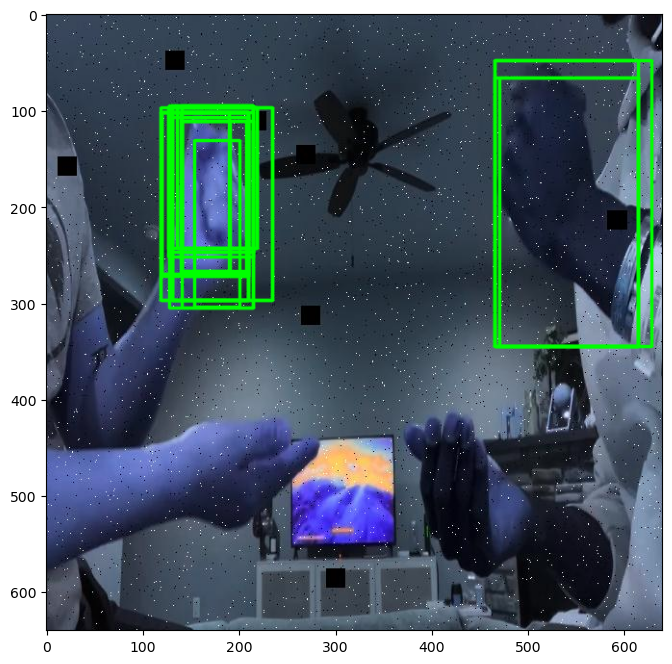

In [124]:

# region_proposals = train_data[itr_arr[0]]['region_proposal']
# bounding_boxes = [entry[0] for entry in region_proposals]
x_min = 640
y_min = 640
x_max = 0
y_max = 0

xt = 6

arrr = []


img22 = cv2.imread(path2 + itr_arr[xt])
for i, rect in (enumerate(train_data[itr_arr[xt]]['region_proposal'])):
    arrr.append(rect)
    x = rect[0][0]
    y = rect[0][1]
    w = rect[0][2]
    h = rect[0][3]
    x_min = min(x_min, x)
    y_min = min(y_min, y)
    x_max = max(x_max, x+ w)
    y_max = max(y_max, y + h)
    
    
    cv2.rectangle(img22, (x, y), (x+w, y+h), (0, 255, 0), 2, cv2.LINE_AA)
    

print(arrr)
# cv2.rectangle(img22, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2, cv2.LINE_AA)
    
plt.figure(figsize=(12,8))
plt.imshow(img22)

In [125]:
rectangles_list = [item[0] for item in arrr]
print(rectangles_list)

[[471, 66, 144, 279], [466, 66, 149, 279], [466, 48, 149, 297], [466, 48, 163, 297], [131, 107, 79, 190], [141, 95, 74, 152], [131, 102, 79, 195], [140, 102, 70, 141], [154, 131, 47, 173], [119, 102, 91, 195], [141, 111, 50, 156], [136, 97, 83, 146], [127, 102, 88, 150], [127, 97, 92, 146], [140, 102, 70, 170], [141, 111, 67, 156], [141, 111, 74, 194], [128, 95, 87, 210], [131, 97, 104, 200], [120, 102, 90, 168], [119, 97, 116, 200], [120, 102, 70, 168], [120, 102, 90, 170], [128, 95, 87, 152]]


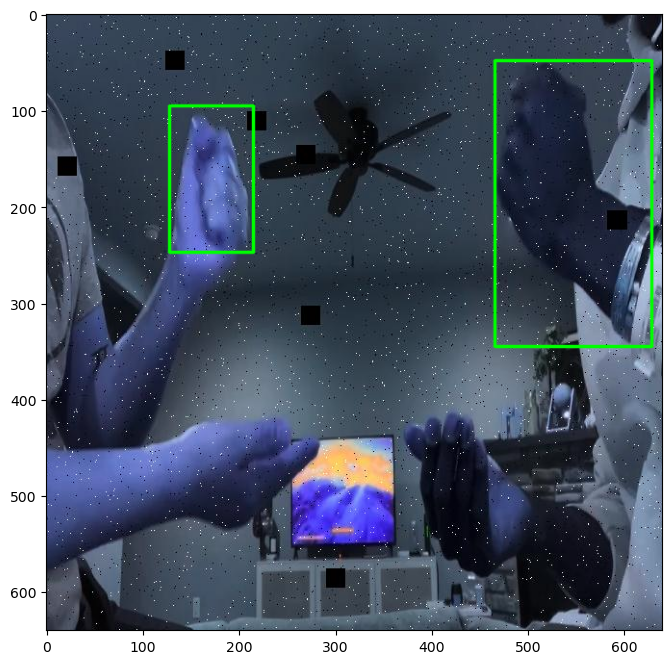

In [131]:
# remove_collisions(rectangles_list)
non_colliding_rect = remove_collisions(rectangles_list)
img23 = cv2.imread(path2 + itr_arr[7])
# non_colliding_rect
for j, rect2 in enumerate(non_colliding_rect):
    x, y, w, h = rect2
    cv2.rectangle(img23, (x, y), (x+w, y+h), (0, 255, 0), 2, cv2.LINE_AA)

plt.figure(figsize=(12,8))
plt.imshow(img23)

In [ ]:
itr_arr1 = []
for file_path in testdata['filename']:
    itr_arr.append(file_path)
itr_arr1

In [ ]:
path3 = './datasets/' + 'test' + '/'

In [ ]:
events_count1 = len(itr_arr1)
for i in range(events_count1):
    cs1, neg1 = iou_filter(path3 + itr_arr1[i], itr_arr1[i] ,testdata, thresh=0.5)
    test_data[itr_arr1[i]] = {'region_proposal':cs1,'negative_example':neg1}
    finished = 100*(i/events_count1)
    print(finished)

In [ ]:
import json
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [ ]:
with open('train.json','w+') as output_file:
    json.dump(train_data,output_file,cls=MyEncoder)

In [ ]:
with open('test.json','w+') as output_file:
    json.dump(test_data,output_file,cls=MyEncoder)

In [ ]:
with open('train.json') as train:
    train_json = json.load(train)

In [ ]:
with open('test.json') as test:
    test_json = json.load(test)

In [ ]:
train_json == train_data

In [ ]:
test_json == test_data